In [ ]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data2 import ExprData2
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
import random
np.random.seed(42)
random.seed(15213)

In [ ]:
name_map = {
    'tpcc': 'TPC-C',
    'tpch': 'TPC-H',
    'twitter': 'Twitter',
    'ycsb': 'YCSB',
    'tpcds': 'TPC-DS',
    'wmc': 'PW'
}

In [ ]:
method='MutualInfoGain'#'RFE' 
est_name = 'LogisticRegression'

In [ ]:
xml_wl_wls = ['18', '19', '20']
candid = '20'

In [ ]:
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(3*len(feature_groups), 2.8))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):       
        curr_labels = [name_map[name] for name in simi_data.wl_names]
        curr_zipped = list(zip(simi_data.wl_groups, curr_labels, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)

    order=['TPC-C', 'TPC-H', 'Twitter']
    if X_p['workload'].nunique() == 4:
        order.append('TPC-DS')
    
    # sns.barplot(x="distance", y="feature_group", hue_order=order, orient = 'h',
    sns.barplot(y="distance", x="feature_group", hue_order=order,
                hue="workload", data=X_p, ax=ax, 
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    # plt.ylabel('')
    # plt.xlabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=4, mode="expand")
               #, borderaxespad=0., fontsize=9) # 
    print(title)
    # plt.title(title)
    plt.savefig(f'figs/new_wmc_{fname}', bbox_inches = 'tight')
    plt.show()

In [ ]:
def plot_scores_single(simi_mtx, simi_data, root_idx, data_type, method_type, note=''):
    fig, ax = plt.subplots(figsize=(5.2,2))
    curr_labels = [name_map[name] for name in simi_data.wl_names]

    zipped = list(zip(simi_data.wl_groups, curr_labels, simi_data.cpu_nums, simi_mtx[root_idx]))
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','cpu_num', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)
    
    order=['TPC-C', 'TPC-H', 'Twitter']
    if X_p['workload'].nunique() == 4:
        order.append('TPC-DS')

    sns.barplot(y="distance", x="workload", order=order, orient = 'h',
    # sns.barplot(x="distance", y="workload", order=order, orient = 'h',
                data=X_p, ax=ax, errorbar="sd",
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    ax.set_xlabel('')
    # handles, labels = ax.get_legend_handles_labels()
    # ax.get_legend().set_visible(False)

    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 

    plt.savefig(f'figs/Test_Single_{candid}_2', bbox_inches = 'tight')
    plt.show()

In [ ]:
data = ExprData2()
data.load_pickle(exclude_wl=[ter for ter in xml_wl_wls if ter != candid ])

In [ ]:
print(list(zip(data.wl_groups, data.wl_names, data.cpu_nums)))

[('1', 'tpcc', '80'), ('2', 'tpcc', '80'), ('3', 'tpcc', '80'), ('4', 'tpcc', '80'), ('1', 'tpcds', '80'), ('2', 'tpcds', '80'), ('3', 'tpcds', '80'), ('4', 'tpcds', '80'), ('5', 'tpcds', '80'), ('6', 'tpcds', '80'), ('7', 'tpcds', '80'), ('8', 'tpcds', '80'), ('10', 'tpch', '80'), ('11', 'tpch', '80'), ('12', 'tpch', '80'), ('13', 'tpch', '80'), ('5', 'tpch', '80'), ('6', 'tpch', '80'), ('7', 'tpch', '80'), ('8', 'tpch', '80'), ('9', 'tpch', '80'), ('10', 'twitter', '80'), ('11', 'twitter', '80'), ('12', 'twitter', '80'), ('13', 'twitter', '80'), ('14', 'twitter', '80'), ('15', 'twitter', '80'), ('16', 'twitter', '80'), ('17', 'twitter', '80'), ('20', 'wmc', '80')]


In [ ]:
candid_idx = data.wl_groups.index(candid)

In [ ]:
# similarity for all
scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(data.plan_mtxs)

simi_calc_all = Similarity(data, plan_mtxs, plan_col_ranges, None, [])
simi_calc_all.calc_bined_mtx(plan_only=True) # all plan features

In [ ]:
simi_calc = simi_calc_all
fs = FeatureSelection(simi_calc)
plan_features = data.plan_feature_cols
plan_top_7 = fs.select_features(7, method, est_name=est_name, direction=None, feature_type='plan')
plan_top_3 = fs.select_features(3, method, est_name=est_name, direction=None, feature_type='plan')
print(plan_top_7)
feature_group_plan = ['plan_3', 'plan_7', 'plan']
features_plan = [plan_top_3, plan_top_7, plan_features]

(30, 30, 22)
(30, 30, 22)
['EstimateIO', 'StatementSubTreeCost', 'AvgRowSize', 'CachedPlanSize', 'CompileMemory', 'StatementEstRows', 'SerialRequiredMemory']
(30, 30, 22)
['EstimateIO', 'AvgRowSize', 'StatementSubTreeCost', 'SerialRequiredMemory', 'StatementEstRows', 'EstimateRows', 'CompileMemory', 'CachedPlanSize', 'EstimateCPU', 'MaxUsedMemory']


In [ ]:
simi_mtxs = []
for feature_group in features_plan:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='canb', normalize=True)
    simi_mtxs.append(simi_calc.simi_mtx)

Base Workload: wmc, Method: 80 Independent.Cumulative Histogram Canb Norm


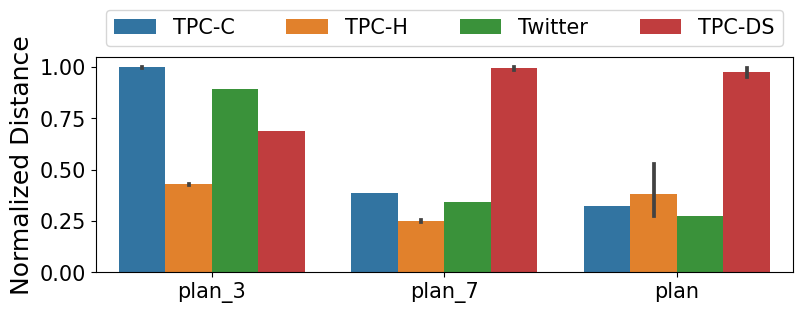

In [15]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_plan, candid_idx, 'Cumulative Histogram Canb Norm', colwise=True, note='')